## Setup

### System Detail & Colab Setup

Enter below code in browser developer console to prevent disconnect.
```
function ClickConnect() {
  console.log('Working')
  document
    .querySelector('#top-toolbar > colab-connect-button')
    .shadowRoot.querySelector('#connect')
    .click()
}
intervalTiming = setInterval(ClickConnect, 60000)
```

In [1]:
!nvidia-smi

Tue Mar  1 10:42:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q -U albumentations
!pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 102 kB 7.1 MB/s 
     |████████████████████████████████| 47.7 MB 1.2 MB/s 
     |████████████████████████████████| 38.2 MB 1.3 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.62
    Uninstalling opencv-python-headless-4.5.5.62:
      Successfully uninstalled opencv-python-headless-4.5.5.62


### Load Dataset
Unarchive zip file on GoogleDrive to local `/content/` directory 

In [3]:
!mkdir "./PascalVOC"
!unzip -qq "/content/drive/MyDrive/Colab Resources/Datasets/PascalVOC.zip" -d "/content/PascalVOC/"

### Import

Reload everytime when python module is updated during runtime.

In [4]:
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader

from importlib import reload
import sys
import os.path 
sys.path.append("/content/drive/MyDrive/Colab Resources/YOLOv1")

from yolo.resnet_model_light import ResnetYoloV1
from yolo.loss import YoloLoss
from yolo.dataset import VOCDataset
from utils.metric import Metric
from utils.image_processes import ResizePreprocess, JitterPreprocess, normalize_imagenet_to_cv2
from utils.box_processes import BoxProcesses
from utils.trainer import Trainer
from utils.inferrer import Inferrer
from utils.visualize import draw_box_on_image

### Set Device

Utilize GPU when available

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Hyperparameters

In [6]:
# Local Hyperparameters etc.
NUM_WORKERS = 2
PIN_MEMORY = True

# Tunable Hyperparameters (in Colab)
BATCH_SIZE = 64
LEARNING_RATE = 0.005
EPOCHS = 135
WEIGHT_DECAY = 0.0005
MODEL_CKPT_PATH = "/content/drive/MyDrive/Colab Resources/YOLOv1/resnet_model.pth.tar"

## Training

### Load Data

In [7]:
train_dataset = VOCDataset(
    csv_file="/content/PascalVOC/train.csv",
    transform=JitterPreprocess(),
    img_dir="/content/PascalVOC/images",
    label_dir="/content/PascalVOC/labels"
)

val_dataset = VOCDataset(
    csv_file="/content/PascalVOC/test.csv",
    transform=ResizePreprocess(),
    img_dir="/content/PascalVOC/images",
    label_dir="/content/PascalVOC/labels"
)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
    drop_last=False
)

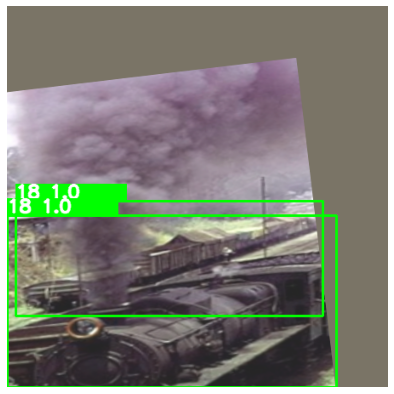

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]
plt.axis('off')


# pick one sample
IMG_NUM = 15
sample_data = train_dataset[IMG_NUM]

# re-process to use visualizer function... 
box_processor = BoxProcesses()
rgb_img = normalize_imagenet_to_cv2(sample_data[0])
bbox = box_processor.boxes_cell_to_list(sample_data[1].unsqueeze(0))[0]
bbox = list(filter(lambda box: box[1]>0, bbox))

draw_box_on_image(rgb_img, bbox, color=[0, 255, 0])
plt.imshow(rgb_img)

### Initialize Model

=> Loading checkpoint
*** Continue previous training... Previous epoch was: 134***


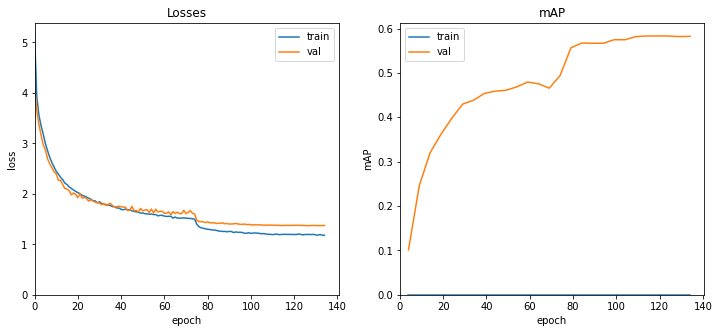

Adjusting learning rate of group 0 to 5.0000e-05.
Best mAP during training was: 0.5832312107086182


In [13]:
# ======
# Initialize Model
# ======
model = ResnetYoloV1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()


# setup trainer
trainer = Trainer(DEVICE)
# load previous training
trainer.launch_model(model, optimizer, MODEL_CKPT_PATH, LOAD_MODEL=True)
# set learning rate scheduler
trainer.launch_training(optimizer)

# setup inferrer
inferrer = Inferrer(DEVICE)


best_mAP = max(trainer.val_mAPs)
print(f"Best mAP during training was: {best_mAP}")

### Epoch Loop

Epoch: 132


100%|██████████| 258/258 [06:46<00:00,  1.58s/it, train_loss=1.25]


Mean train loss was      1.1934818874957949
Mean validation loss was 1.3696038952240577
Adjusting learning rate of group 0 to 5.0000e-05.
=> Saving checkpoint: Epoch=132
Epoch: 133


100%|██████████| 258/258 [06:49<00:00,  1.59s/it, train_loss=1.15]


Mean train loss was      1.1818590323592342
Mean validation loss was 1.3722404012313256
Adjusting learning rate of group 0 to 5.0000e-05.
=> Saving checkpoint: Epoch=133
Epoch: 134


100%|██████████| 258/258 [07:20<00:00,  1.71s/it, train_loss=0.991]


Mean train loss was      1.181085956651111
Mean validation loss was 1.3739491685842857
Adjusting learning rate of group 0 to 5.0000e-05.
Train mAP: 0, Validation mAP: 0.5822993516921997


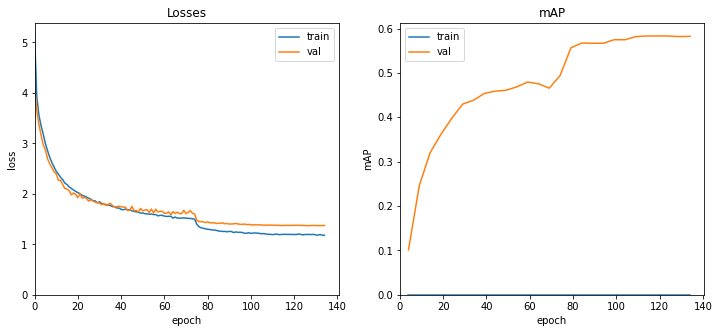

=> Saving checkpoint: Epoch=134


In [10]:
# =====
# Epoch Loop
# =====
for epoch in range(trainer.prev_epoch+1, EPOCHS):
    print(f"Epoch: {epoch}")

    # Training
    train_mean_loss, val_mean_loss = trainer.epoch_train_fn(train_loader, val_loader, model, optimizer, loss_fn)
    # Record losses
    trainer.record_losses(train_mean_loss, val_mean_loss)
    
    if (epoch+1) % 1 == 0:
        
        if (epoch+1) % 5 == 0:
            # Check mAP performance
            train_mAP = 0
            val_mAP = trainer.check_mAP(val_loader, model, inferrer)
            print(f"Train mAP: {train_mAP}, Validation mAP: {val_mAP}")
            # Record mAPs
            trainer.record_mAPs(train_mAP, val_mAP)

            # Plot record
            trainer.plot_training()

        # Save checkpoint during training
        trainer.save_training(model, optimizer, epoch, filename=MODEL_CKPT_PATH)
        


## Evaluation

### Mean Average Precision 

In [11]:
mean_avg_prec = trainer.check_mAP(val_loader, model, inferrer)
print(f"Test mAP: {mean_avg_prec}")

Test mAP: 0.5822993516921997


### Visualize
Plot a validation batch

In [12]:
import numpy as np
import time

batch = next(iter(val_loader))
all_pred_boxes, all_true_boxes = inferrer.infer_labeled(val_loader, model, iou_threshold=0.5, threshold=0.1)


for IMG_IDX in range(len(batch[0])):
    # filter out bboxes of current image
    pred_bboxes = [
        bbox[1:8]
        for bbox in all_pred_boxes
        if bbox[0] == IMG_IDX
    ]
    gt_bboxes = [
        bbox[1:8]
        for bbox in all_true_boxes
        if bbox[0] == IMG_IDX
    ]


    # draw boxes on image
    rgb_image = normalize_imagenet_to_cv2(batch[0][IMG_IDX])
    draw_box_on_image(rgb_image, gt_bboxes, color=[0, 255, 0])
    draw_box_on_image(rgb_image, pred_bboxes, color=[255, 0, 0])

    # plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(rgb_image)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.